# Training the Language-Based Type Estimator

For code change detection, seeing log messages inside the notebook, and checking TensorFlow configuration.

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import tensorflow as tf
logger: logging.Logger = logging.getLogger()
logger.setLevel(logging.INFO)

logging.info(f"Tensorflow version {tf.__version__}")
logging.info(f"Devices available: {tf.config.list_physical_devices()}")

logging.info("Starting analysis...")

2022-12-23 13:58:14.376949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 13:58:14.455828: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-23 13:58:14.814331: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-23 13:58:14.814443: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## Data Exploration

Checking label counts on the training dataset

<AxesSubplot: xlabel='will_help', ylabel='count'>

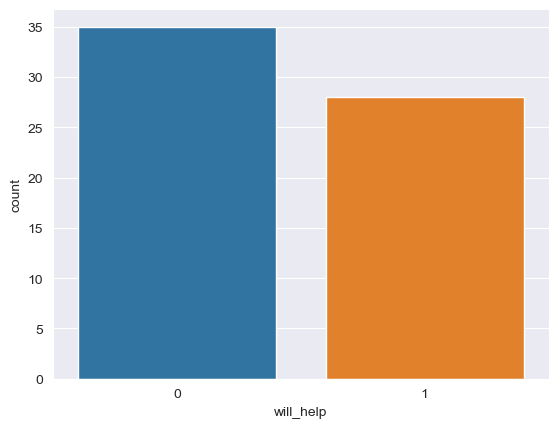

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

TRAINING_DATA_CSV_FILE = "data/training_data.csv"
training_dataset: pd.DataFrame = pd.read_csv(TRAINING_DATA_CSV_FILE)
validation_dataset: pd.DataFrame
training_dataset, validation_dataset = train_test_split(training_dataset, test_size=0.5)

sns.countplot(x="will_help", data=training_dataset)

## Sanity Check

Let's train on a single sample, to verify data loading is working fine. We expect perfect accuracy after a few iterations.

In [ ]:
from transformer_analyser import TransformerTypeAnalyser

type_analyser: TransformerTypeAnalyser = TransformerTypeAnalyser(epochs=5)
type_analyser.train(training_dataset.head(1))

INFO:root:Starting training...
2022-12-23 13:58:16.376413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 13:58:16.377537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 13:58:16.377807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 13:58:16.377881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had

RuntimeError: Can't decrement id ref count (file write failed: time = Fri Dec 23 13:58:18 2022
, filename = '/tmp/tmp0ec_zt22/variables.h5', file descriptor = 80, errno = 28, error message = 'No space left on device', buf = 0x5651f16c4f60, total write size = 5168, bytes this sub-write = 5168, bytes actually written = 18446744073709551615, offset = 0)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py/_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Fri Dec 23 13:58:18 2022
, filename = '/tmp/tmp0ec_zt22/variables.h5', file descriptor = 80, errno = 28, error message = 'No space left on device', buf = 0x5651f16c4f60, total write size = 5168, bytes this sub-write = 5168, bytes actually written = 18446744073709551615, offset = 0)


  0%|          | 0/1 [00:00<?, ?ba/s]

INFO:root:Encoding finished!


Epoch 1/5


2022-12-23 13:58:30.871362: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7184024540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-23 13:58:30.871379: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000 Laptop GPU, Compute Capability 8.6
2022-12-23 13:58:30.874450: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-23 13:58:30.935878: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-23 13:58:30.936776: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234]

1/1 [==============================] - 22s 22s/step - loss: 0.7060 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 0s 65ms/step - loss: 0.4766 - sparse_categorical_accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 0s 65ms/step - loss: 0.3328 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 0s 65ms/step - loss: 0.2981 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 63ms/step - loss: 0.4499 - sparse_categorical_accuracy: 1.0000
